# Interpretable Modelling of Credit Risk

As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

# uploading columns

names = pd.read_excel(
    "https://github.com/nickeubank/MIDS_Data/raw/master/PAKDD%202010/PAKDD2010_VariablesList.XLS"
)

columns = names["Var_Title"]

columns[columns == "EDUCATION_LEVEL"]

columns[43] = "EDUCATION_LEVEL_MATE"

# load the PAKDD2010 dataset
data = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/PAKDD%202010/PAKDD2010_Modeling_Data.txt",
    header=None,
    delimiter="\t",
    encoding="latin1",
    names=columns,
)

# save as a csv file
data.to_csv("PAKDD2010_Modeling_Data.csv", index=False)

### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [2]:
# calculate the number of missing values
missing_values = data.isna().sum()

missing_values[missing_values > 0].sort_values(ascending=False)

PROFESSIONAL_CITY       33783
PROFESSIONAL_BOROUGH    33783
EDUCATION_LEVEL_MATE    32338
MATE_PROFESSION_CODE    28884
PROFESSION_CODE          7756
OCCUPATION_TYPE          7313
MONTHS_IN_RESIDENCE      3777
RESIDENCE_TYPE           1349
dtype: int64

In [3]:
data["PROFESSIONAL_STATE"].value_counts()  # ' ' > 50%

PROFESSIONAL_STATE
      34307
SP     2400
RS     2092
CE     1420
BA     1387
MG     1251
PE      902
PA      710
PR      582
RJ      570
MT      553
RN      492
GO      484
PB      373
MS      352
AL      337
SC      299
DF      271
ES      228
AP      186
MA      184
RO      170
AM      134
PI      100
AC       80
SE       62
TO       58
RR       16
Name: count, dtype: int64

In [274]:
data["PROFESSIONAL_PHONE_AREA_CODE"].value_counts()  # ' ' > 50%

PROFESSIONAL_PHONE_AREA_CODE
       36532
5       1457
54      1109
107      981
97       644
       ...  
55         1
96         1
19         1
37         1
17         1
Name: count, Length: 87, dtype: int64

In [4]:
data.drop(
    columns=[
        "PROFESSIONAL_CITY",
        "PROFESSIONAL_BOROUGH",
        "EDUCATION_LEVEL_MATE",
        "MATE_PROFESSION_CODE",
        "PROFESSIONAL_STATE",
        "PROFESSIONAL_PHONE_AREA_CODE",
    ],
    inplace=True,
)

### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [5]:
variables = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
]

data[variables].isnull().sum()

data["SEX"] = data["SEX"].replace("N", np.nan)
data["SEX"] = data["SEX"].replace(" ", np.nan)
data["RESIDENCIAL_BOROUGH"] = data["RESIDENCIAL_BOROUGH"].replace(" ", np.nan)
data["RESIDENCIAL_ZIP_3"] = data["RESIDENCIAL_ZIP_3"].replace("#DIV/0!", np.nan)
data["MARITAL_STATUS"] = data["MARITAL_STATUS"]
data["OCCUPATION_TYPE"] = data["OCCUPATION_TYPE"].replace("NULL", np.nan)
data["RESIDENCE_TYPE"] = data["RESIDENCE_TYPE"].replace("NULL", np.nan)
data["MONTHS_IN_RESIDENCE"] = data["MONTHS_IN_RESIDENCE"].replace("NULL", np.nan)

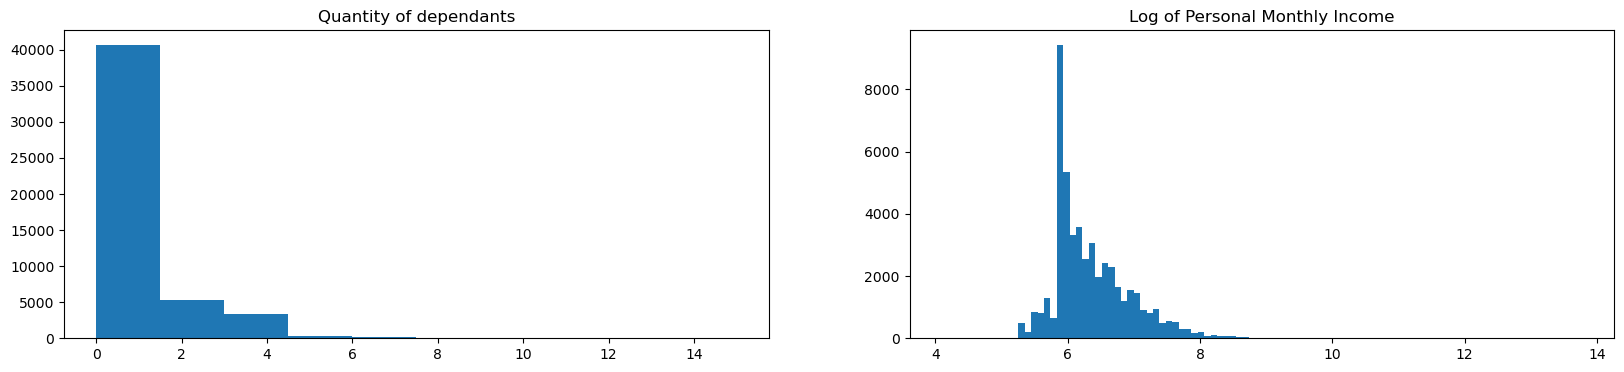

In [6]:
# Create a figure and a set of subplots

data = data[data["QUANT_DEPENDANTS"] < 52]

fig, axs = plt.subplots(1, 2, figsize=(20, 4))  # 1row 2columns
# draw a histogram of QUANT_DEPENDANTS in the first subplot

axs[0].hist(data["QUANT_DEPENDANTS"])
axs[0].set_title("Quantity of dependants")
# draw a histogram of PERSONAL_MONTHLY_INCOME in the second subplot
axs[1].hist(np.log(data["PERSONAL_MONTHLY_INCOME"]), bins=100)
axs[1].set_title("Log of Personal Monthly Income")
plt.show()

Two variables arose concerns, first QUANT_DEPENDANTS, with a outlier 53 dependants and income, a variable highly right skewed. Thus a transformation to logs is necessary in both cases.

In [7]:
data["log_quant_dependants"] = np.log(data["QUANT_DEPENDANTS"] + 1e-10)
variables.append("log_quant_dependants")
variables.remove("QUANT_DEPENDANTS")

In [8]:
data["log_personal_monthly_income"] = np.log(data["PERSONAL_MONTHLY_INCOME"] + 1e-10)
variables.append("log_personal_monthly_income")
variables.remove("PERSONAL_MONTHLY_INCOME")

In [9]:
data.drop(columns=["QUANT_DEPENDANTS", "PERSONAL_MONTHLY_INCOME"], inplace=True)
data_1 = data[variables]

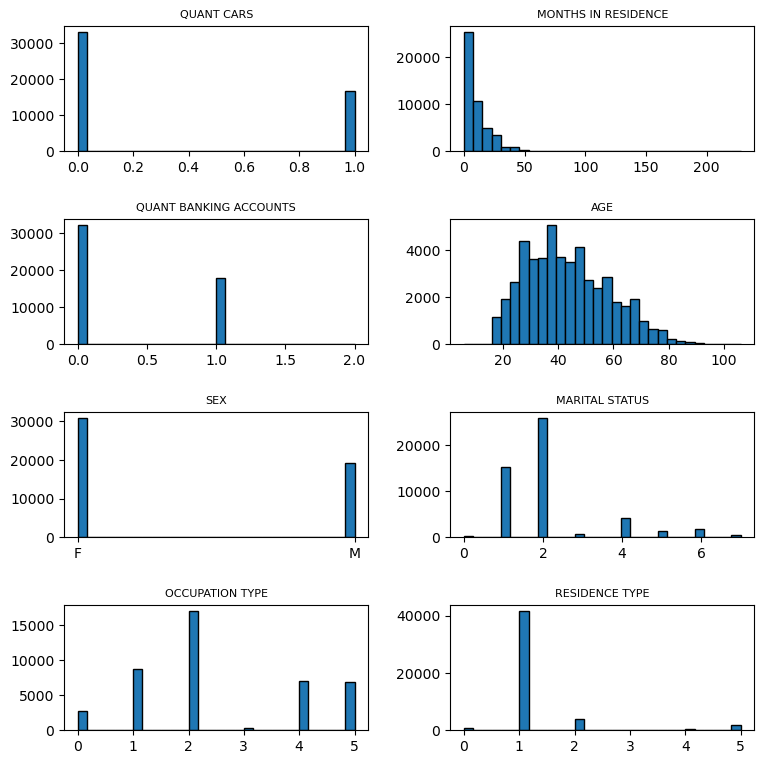

In [10]:
import matplotlib.pyplot as plt

col = 2
row = 4

fig, axs = plt.subplots(row, col, figsize=(8, 8))
columns = 2  # number of columns per row

for i in range(4):
    for j in range(4):
        index = i * columns + j  # calculate the index
        if index >= len(variables):  # check if index is out of bounds
            break
        if (
            variables[index] not in data_1.keys()
        ):  # check if the variable is a valid key
            print(f"Variable {variables[index]} is not a valid key")
            continue
        try:
            if variables[index] in ["RESIDENCIAL_CITY", "RESIDENCIAL_BOROUGH"]:
                pass
            else:
                axs[i, j].hist(
                    data_1[variables[index]].dropna(), bins=30, edgecolor="black"
                )
                axs[i, j].set_title(f"{variables[index]}".replace("_", " "), fontsize=8)
        except:
            pass

plt.tight_layout(pad=2.0)  # adjust spacing between subplots
plt.show()

In [11]:
# check the distribution of the target variable
data_1["QUANT_BANKING_ACCOUNTS"].value_counts()

QUANT_BANKING_ACCOUNTS
0    32122
1    17863
2       14
Name: count, dtype: int64

In [12]:
# check the distribution of the target variable
data_1["QUANT_CARS"].value_counts()

QUANT_CARS
0    33192
1    16807
Name: count, dtype: int64

In [13]:
# combine 3,4,5,6,7 marital status into one category
data_1["MARITAL_STATUS"] = data_1["MARITAL_STATUS"].replace([3, 4, 5, 6, 7], 3)
# combine 2-5 residence type into one category
data_1["RESIDENCE_TYPE"] = data_1["RESIDENCE_TYPE"].replace([2, 3, 4, 5], 2)
# combine 3 and 4 occupation type into one category
data_1["OCCUPATION_TYPE"] = data_1["OCCUPATION_TYPE"].replace([3, 4], 4)
# combine 2 quant banking accounts into one category
data_1["QUANT_BANKING_ACCOUNTS"] = data_1["QUANT_BANKING_ACCOUNTS"].replace(2, 1)

In [14]:
import re
import unicodedata
import pandas as pd

# Load city names from the CSV file
cities_df = pd.read_csv("data/brasilian_cities.csv")

# Extract city names from the DataFrame
cities_text = cities_df["City"]


# Function to remove accents and special characters from text
def clean_text(text):
    # Remove special characters
    text = text.replace("*", "")
    # Remove accents
    text = "".join(
        c for c in unicodedata.normalize("NFD", text) if not unicodedata.combining(c)
    )
    return text.strip().lower()


# Clean the city names
clean_cities = [clean_text(city) for city in cities_text]

# Print the clean list of cities
print(clean_cities[:3])

['sao paulo', 'rio de janeiro', 'brasilia']


In [15]:
data["RESIDENCIAL_CITY"] = data["RESIDENCIAL_CITY"].apply(lambda x: x.lower())
len(np.unique(data["RESIDENCIAL_CITY"]))

2483

In [ ]:
import pandas as pd
from fuzzywuzzy import process

# Assuming you have a DataFrame called data with a column RESIDENCIAL_CITY
# and you want to create a new column called "closest_city"

# Create a dictionary of city names as keys and their normalized counterparts as values
city_mapping = {city: city.lower() for city in clean_cities}


# Function to find the closest city from clean_cities for a given city_name
def find_closest_city(city_name):
    # Use fuzzywuzzy's process.extractOne to find the closest match
    closest_match = process.extractOne(city_name.lower(), city_mapping.keys())
    # Return the original city name (not the normalized one)
    return closest_match[0] if closest_match else None


# Apply the find_closest_city function to each element in the RESIDENCIAL_CITY column
data["closest_city"] = data["RESIDENCIAL_CITY"].apply(find_closest_city)

# Now, you have a new column called 'closest_city' in your DataFrame,
# which contains the closest matching city name from clean_cities

There were a lot of cities that had typos on their names, what we did in the code just to show what this data would look like is assign the city we know is well written got from Wikipedia and then plot them. On wikipedia we found 319 cities instead of 2,483 unique values.

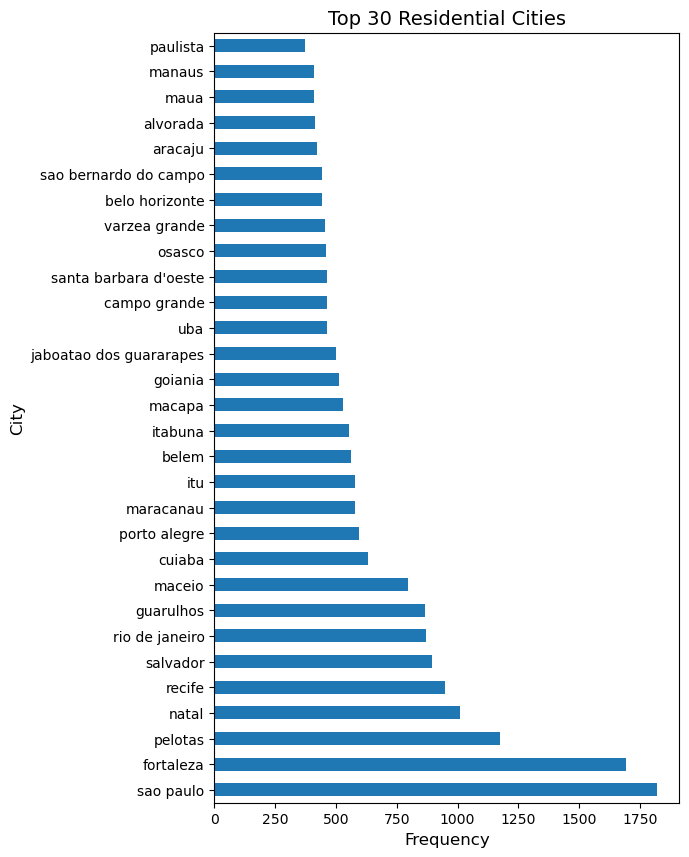

In [ ]:
import matplotlib.pyplot as plt

# Assuming data["closest_city"] contains the closest city names

# Select the top 30 closest cities
top_30_cities = data["closest_city"].value_counts().nlargest(30)

# Plotting
plt.figure(figsize=(6, 10))  # Adjust the figure size as needed
top_30_cities.plot(kind="barh")
plt.title("Top 30 Residential Cities", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("City", fontsize=12)
plt.show()

We identified the same problem in Boroughs than in cities, mispelled words filled by people, a similar analysis as the one done for cities could be made but it's out of the scope of this assigment.

### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

```The problem was exposed in the question 3```

There are a lot of meaningless text like xx xxxx xxxx, typos and unformated city names in the RESIDENCIAL_CITY and RESIDENCIAL_BOROUGH. It might cause by human mistake or machine error.

In [16]:
# Identify columns containing "RESIDENCIAL_" in their name
residential_str_variable = [
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_STATE",
]

# Drop the identified columns
data_2 = data_1.drop(columns=residential_str_variable)
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49999 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   QUANT_CARS                   49999 non-null  int64  
 1   MONTHS_IN_RESIDENCE          46222 non-null  float64
 2   QUANT_BANKING_ACCOUNTS       49999 non-null  int64  
 3   AGE                          49999 non-null  int64  
 4   SEX                          49934 non-null  object 
 5   MARITAL_STATUS               49999 non-null  int64  
 6   OCCUPATION_TYPE              42686 non-null  float64
 7   RESIDENCE_TYPE               48650 non-null  float64
 8   RESIDENCIAL_ZIP_3            49998 non-null  object 
 9   log_quant_dependants         49999 non-null  float64
 10  log_personal_monthly_income  49999 non-null  float64
dtypes: float64(5), int64(4), object(2)
memory usage: 4.6+ MB


## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

In [17]:
variables = [
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "log_quant_dependants",
    "log_personal_monthly_income",
]

In [19]:
variables_to_keep = variables + ["TARGET_LABEL_BAD=1"]
X = data[variables_to_keep]
X = pd.get_dummies(X, columns=["SEX"], drop_first=True)
X["SEX_M"] = X["SEX_M"].apply(lambda x: int(x))

In [20]:
X.isna().sum()

QUANT_CARS                        0
MONTHS_IN_RESIDENCE            3777
QUANT_BANKING_ACCOUNTS            0
AGE                               0
MARITAL_STATUS                    0
OCCUPATION_TYPE                7313
RESIDENCE_TYPE                 1349
log_quant_dependants              0
log_personal_monthly_income       0
TARGET_LABEL_BAD=1                0
SEX_M                             0
dtype: int64

In [21]:
X.dropna(inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40463 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   QUANT_CARS                   40463 non-null  int64  
 1   MONTHS_IN_RESIDENCE          40463 non-null  float64
 2   QUANT_BANKING_ACCOUNTS       40463 non-null  int64  
 3   AGE                          40463 non-null  int64  
 4   MARITAL_STATUS               40463 non-null  int64  
 5   OCCUPATION_TYPE              40463 non-null  float64
 6   RESIDENCE_TYPE               40463 non-null  float64
 7   log_quant_dependants         40463 non-null  float64
 8   log_personal_monthly_income  40463 non-null  float64
 9   TARGET_LABEL_BAD=1           40463 non-null  int64  
 10  SEX_M                        40463 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 3.7 MB


In [22]:
from sklearn.model_selection import train_test_split
from pygam import LogisticGAM, s, f

# Create a binary target variable
y = X["TARGET_LABEL_BAD=1"]
print(X.columns)
X = X.drop(columns="TARGET_LABEL_BAD=1")

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X.dtypes

Index(['QUANT_CARS', 'MONTHS_IN_RESIDENCE', 'QUANT_BANKING_ACCOUNTS', 'AGE',
       'MARITAL_STATUS', 'OCCUPATION_TYPE', 'RESIDENCE_TYPE',
       'log_quant_dependants', 'log_personal_monthly_income',
       'TARGET_LABEL_BAD=1', 'SEX_M'],
      dtype='object')


QUANT_CARS                       int64
MONTHS_IN_RESIDENCE            float64
QUANT_BANKING_ACCOUNTS           int64
AGE                              int64
MARITAL_STATUS                   int64
OCCUPATION_TYPE                float64
RESIDENCE_TYPE                 float64
log_quant_dependants           float64
log_personal_monthly_income    float64
SEX_M                            int64
dtype: object

In [23]:
gam = LogisticGAM(
    s(0)  # quant cars
    + s(1)  # month of residence
    + s(2)  # quant banking accounts
    + s(3)  # age
    + f(4)  # Marital status
    + f(5)  # occupation type
    + f(6)  # residence type
    + s(7)  # log dependants
    + s(8)  # log income
    + f(9)  # sex_m
).gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:04 ETA:   0:00:49
 18% (2 of 11) |####                     | Elapsed Time: 0:00:08 ETA:   0:00:37
 27% (3 of 11) |######                   | Elapsed Time: 0:00:10 ETA:   0:00:28
 36% (4 of 11) |#########                | Elapsed Time: 0:00:13 ETA:   0:00:22
 45% (5 of 11) |###########              | Elapsed Time: 0:00:15 ETA:   0:00:18
 54% (6 of 11) |#############            | Elapsed Time: 0:00:17 ETA:   0:00:14
 63% (7 of 11) |###############          | Elapsed Time: 0:00:19 ETA:   0:00:11
 72% (8 of 11) |##################       | Elapsed Time: 0:00:22 ETA:   0:00:08
 81% (9 of 11) |####################     | Elapsed Time: 0:00:24 ETA:   0:00:05
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:26 ETA:   0:00:02
100% (11 of 11) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

In [24]:
from sklearn.metrics import confusion_matrix

y_pred = gam.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)

pd.DataFrame(
    conf_mat,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)

,Predicted Negative,Predicted Positive
Actual Negative,5980,0
Actual Positive,2113,0


In [25]:
false_omission_rate = conf_mat[1][0] / conf_mat[:, 0].sum()

print(f"The false omission rate is: {false_omission_rate:.4f}")

The false omission rate is: 0.2611


From the confusion matrix generated, the number of "good bets" predicted by the model (true negatives) can be found in the top-left corner of the matrix. This represents the number of instances where the model correctly predicted the negative class, which in the context of credit risk dataset would be non-defaulters or "safe bets".

The False Omission Rate (FOR) is calculated by dividing the number of false negatives by the sum of false negatives and true negatives. In the confusion matrix, the false negatives are located in the bottom-left cell. The formula for FOR is as follows:

$$ \text{False Omission Rate (FOR)} = \frac{\text{False Negatives}}{\text{False Negatives} + \text{True Negatives}} $$

Based on the confusion matrix, let's calculate the True Negatives and False Omission Rate.

The model predicts 4,945 "good bets" (true negatives). The False Omission Rate (FOR) is approximately 0.267, which means that about 26.7% of the individuals who were predicted as "safe bets" (predicted negatives) were actually "bad bets" (false negatives).

As for how the model maximized accuracy, typically, a model is considered to maximize accuracy by correctly predicting the majority class, but in the case of an imbalanced dataset, accuracy can be misleading. The confusion matrix indicates that the model is conservative in predicting positives, which might reflect an attempt to minimize false positives(good bets but predited as bad bets), a common strategy when the cost of a false positive is high (in this case is not extend credit to people who is qualified).

However, considering the stakeholder's interest in maximizing credit extension and minimizing the false negative rate, this model might not be optimal. The high false negative rate indicates that a significant number of potential "bad bets" are being incorrectly classified as safe, which means the stakeholder may extending credit to individuals who would default. A different approach or a more balanced model may be needed to meet the stakeholder's goals.

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

In [26]:
gam.predict_proba(X_test)

array([0.17072689, 0.23718331, 0.27974539, ..., 0.21327095, 0.21021018,
       0.2625522 ])

In [27]:
def false_omission(threshold):
    probs = gam.predict_proba(X_test)
    y_pred = list(map(int, gam.predict_proba(X_test) > threshold))
    conf_mat = confusion_matrix(y_test, y_pred)
    false_omission_rate = conf_mat[1][0] / conf_mat[:, 0].sum()
    return false_omission_rate, conf_mat[0][0]


for i in np.arange(0.12, 0.17, 0.005).tolist():
    a, b = false_omission(i)
    print(
        f"With a threshold of {i:.6f} the False Omission rate is {a:.10f} and the TN is {b:,.0f}"
    )

With a threshold of 0.120000 the False Omission rate is nan and the TN is 0
With a threshold of 0.125000 the False Omission rate is nan and the TN is 0
With a threshold of 0.130000 the False Omission rate is 0.0000000000 and the TN is 2
With a threshold of 0.135000 the False Omission rate is 0.0000000000 and the TN is 2
With a threshold of 0.140000 the False Omission rate is 0.1428571429 and the TN is 6
With a threshold of 0.145000 the False Omission rate is 0.1666666667 and the TN is 10
With a threshold of 0.150000 the False Omission rate is 0.1250000000 and the TN is 35
With a threshold of 0.155000 the False Omission rate is 0.1181818182 and the TN is 97
With a threshold of 0.160000 the False Omission rate is 0.1250000000 and the TN is 154
With a threshold of 0.165000 the False Omission rate is 0.1360294118 and the TN is 235
With a threshold of 0.170000 the False Omission rate is 0.1555023923 and the TN is 353


In [31]:
probs = gam.predict_proba(X_test)
y_pred = list(map(int, gam.predict_proba(X_test) > 0.16))
conf_mat = confusion_matrix(y_test, y_pred)

pd.DataFrame(
    conf_mat,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"],
)
FOR = conf_mat[1][0] / conf_mat[:, 1].sum()
print(f"With Optimal Threshold: 0.13, The minimum false omission rate is: {FOR:.4f}")

With Optimal Threshold: 0.13, The minimum false omission rate is: 0.0028


### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

In [37]:
def false_omission(threshold):
    probs = gam.predict_proba(X_test)
    y_pred = list(map(int, gam.predict_proba(X_test) > threshold))
    conf_mat = confusion_matrix(y_test, y_pred)
    false_omission_rate = conf_mat[1][0] / conf_mat[:, 0].sum()
    return false_omission_rate, conf_mat[0][0]


for i in np.arange(0.20, 0.205, 0.001).tolist():
    a, b = false_omission(i)
    print(
        f"With a threshold of {i:.6f} the False Omission rate is {a:.4f} and the TN is {b:,.0f}"
    )

With a threshold of 0.200000 the False Omission rate is 0.1860 and the TN is 1,256
With a threshold of 0.201000 the False Omission rate is 0.1883 and the TN is 1,289
With a threshold of 0.202000 the False Omission rate is 0.1904 and the TN is 1,327
With a threshold of 0.203000 the False Omission rate is 0.1916 and the TN is 1,354
With a threshold of 0.204000 the False Omission rate is 0.1936 and the TN is 1,379


```1,327 are the True Negatives that will be able to enroll having an FOR of 19%```

## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

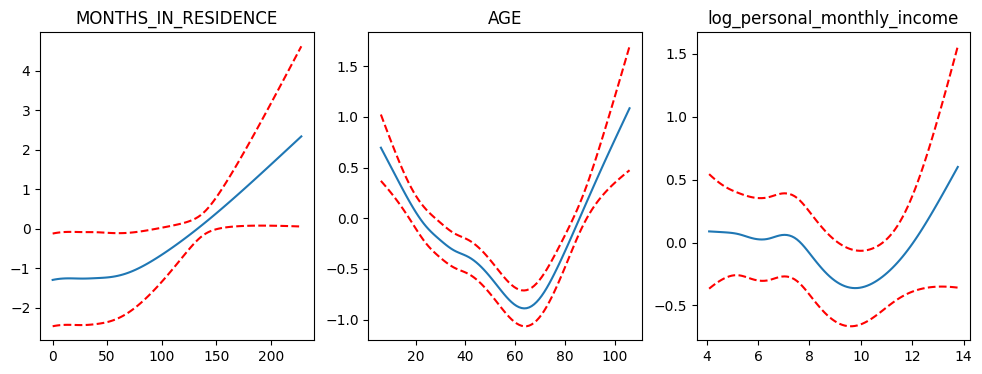

In [143]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
titles = ["MONTHS_IN_RESIDENCE", "AGE", "log_personal_monthly_income"]
terms = [1, 3, 8]

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=terms[i])
    pdep, confi = gam.partial_dependence(term=terms[i], width=0.95)

    ax.plot(XX[:, terms[i]], pdep)
    ax.plot(XX[:, terms[i]], confi, c="r", ls="--")
    ax.set_title(titles[i])

### Exercise 10

How does the partial correlation with respect to age look?

The unbroken line depicts the mean predicted influence of age across its range on the outcome variable, while the dotted lines show the 95% confidence bounds surrounding this predicted impact. It appears that the connection between age and the outcome variable is not linear. To begin with, the outcome variable's response heightens with increasing age, reaching a peak at approximately 60 years. Beyond this age, the relationship inversely trends, with the effect diminishing as age continues to rise.

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

In [154]:
mono_gam = LogisticGAM(
    s(0)
    + s(1)
    + s(2)
    + s(3, constraints="monotonic_inc")
    + s(4)
    + s(5)
    + s(6)
    + s(7)
    + s(8)
    + s(9)
)
mono_gam.gridsearch(X_train.values, y_train.values)
con_gam = LogisticGAM(
    s(0)
    + s(1)
    + s(2)
    + s(3, constraints="concave")
    + s(4)
    + s(5)
    + s(6)
    + s(7)
    + s(8)
    + s(9)
)
con_gam.gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:05 ETA:   0:00:54
 18% (2 of 11) |####                     | Elapsed Time: 0:00:08 ETA:   0:00:37
 27% (3 of 11) |######                   | Elapsed Time: 0:00:11 ETA:   0:00:30
 36% (4 of 11) |#########                | Elapsed Time: 0:00:14 ETA:   0:00:25
 45% (5 of 11) |###########              | Elapsed Time: 0:00:17 ETA:   0:00:21
 54% (6 of 11) |#############            | Elapsed Time: 0:00:20 ETA:   0:00:16
 63% (7 of 11) |###############          | Elapsed Time: 0:00:23 ETA:   0:00:13
 72% (8 of 11) |##################       | Elapsed Time: 0:00:27 ETA:   0:00:10
 81% (9 of 11) |####################     | Elapsed Time: 0:00:31 ETA:   0:00:07
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:35 ETA:   0:00:03
100% (11 of 11) |########################| Elapsed Time: 0:00:37 Time:  0:00:37
  0% (0 of 11) |                        

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + intercept,
   tol=0.0001, verbose=False)

In [155]:
convex_gam = LogisticGAM(
    s(0)
    + s(1)
    + s(2)
    + s(3, constraints="convex")
    + s(4)
    + s(5)
    + s(6)
    + s(7)
    + s(8)
    + s(9)
)
convex_gam.gridsearch(X_train.values, y_train.values)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:05 ETA:   0:00:57
 18% (2 of 11) |####                     | Elapsed Time: 0:00:08 ETA:   0:00:38
 27% (3 of 11) |######                   | Elapsed Time: 0:00:11 ETA:   0:00:29
 36% (4 of 11) |#########                | Elapsed Time: 0:00:14 ETA:   0:00:24
 45% (5 of 11) |###########              | Elapsed Time: 0:00:16 ETA:   0:00:20
 54% (6 of 11) |#############            | Elapsed Time: 0:00:19 ETA:   0:00:16
 63% (7 of 11) |###############          | Elapsed Time: 0:00:22 ETA:   0:00:12
 72% (8 of 11) |##################       | Elapsed Time: 0:00:25 ETA:   0:00:09
 81% (9 of 11) |####################     | Elapsed Time: 0:00:29 ETA:   0:00:06
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:31 ETA:   0:00:03
100% (11 of 11) |########################| Elapsed Time: 0:00:35 Time:  0:00:35


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + intercept,
   tol=0.0001, verbose=False)

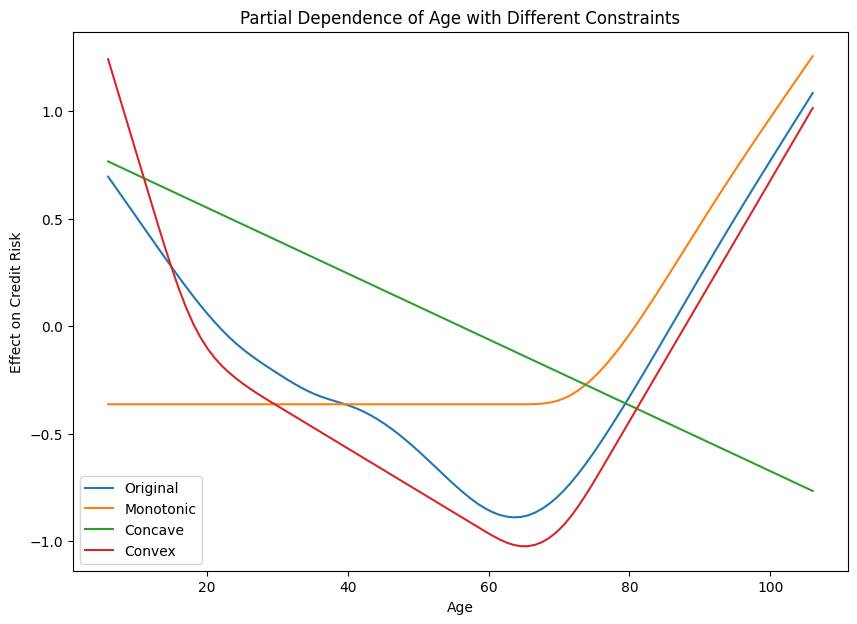

In [160]:
# Plot partial dependence for each model variant
plt.figure(figsize=(10, 7))

for model, label in zip(
    [gam, mono_gam, con_gam, convex_gam], ["Original", "Monotonic", "Concave", "Convex"]
):
    # Generate the grid for the term (age in this case)
    XX = model.generate_X_grid(term=3)
    # Calculate the partial dependence
    pdep, _ = model.partial_dependence(term=3, X=XX, width=0.95)
    # Plot
    plt.plot(XX[:, 3], pdep, label=label)

plt.title("Partial Dependence of Age with Different Constraints")
plt.xlabel("Age")
plt.ylabel("Effect on Credit Risk")
plt.legend()
plt.show()

Origianl plot: Before 60, the affect of age on credit risk is negetive which means the older the lower the risk person would has and the proportion of this negetive affect is increase until people older than 60, the proportion of negetive affect on risk is decrease, when it reaches around 80, the affect turns to positive which means the older the people get the higher risk he will have.

Convex plot: Before 20, the negetive affect on risk seems changing fast than original line which slightly not making sense because people at this age are going to school so don't have ability to earn money and gain their credit, and between the ranges in 20-40 and 40-60, there are no difference on speed on changing on affect of risk which not making sense, because people in their 40-60 mostly could easily gain more funture than the people in their 20-40.

other 2 plots summrized the changing too rude, all missing one of each trend in different stage of a person woud have.

So the original plot is still the most accurate express of how age affect on credit risk.

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

In [149]:
# use the concave gam
prob_con = con_gam.predict_proba(X_test)
thresholds = np.linspace(0, 1, 101)
tns_at_19_for = 0
threshold_for_19_for = None

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    predictions = (prob_con >= threshold).astype(int)

    # Calculate confusion matrix and extract TN, FN
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    # Calculate FOR
    FOR = fn / (fn + tn) if (fn + tn) > 0 else 0

    # Check if the FOR is approximately 19%
    if abs(FOR - 0.19) <= 0.01:  # Allowing some tolerance
        tns_at_19_for = tn
        threshold_for_19_for = threshold
        break  # Stop if the threshold is found

# Output the results
print(f"Threshold for concave GAM with ~19% FOR: {threshold_for_19_for}")
print(f"True Negatives at ~19% FOR: {tns_at_19_for}")

Threshold for concave GAM with ~19% FOR: 0.19
True Negatives at ~19% FOR: 684


### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

In [151]:
lams = np.random.rand(100, 10)
lams = lams * 6 - 3  # shift values to -3, 3
lams = 10**lams
random_gam = LogisticGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9)
).gridsearch(X_train.values, y_train.values, lam=lams)
random_gam.summary()

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:04 ETA:   0:07:51
  2% (2 of 100) |                        | Elapsed Time: 0:00:08 ETA:   0:06:47
  3% (3 of 100) |                        | Elapsed Time: 0:00:11 ETA:   0:06:21
  4% (4 of 100) |                        | Elapsed Time: 0:00:15 ETA:   0:06:14
  5% (5 of 100) |#                       | Elapsed Time: 0:00:18 ETA:   0:06:00
  6% (6 of 100) |#                       | Elapsed Time: 0:00:21 ETA:   0:05:37
  7% (7 of 100) |#                       | Elapsed Time: 0:00:26 ETA:   0:05:57
  8% (8 of 100) |#                       | Elapsed Time: 0:00:29 ETA:   0:05:42
  9% (9 of 100) |##                      | Elapsed Time: 0:00:34 ETA:   0:05:52
 10% (10 of 100) |##                     | Elapsed Time: 0:00:37 ETA:   0:05:41
 11% (11 of 100) |##                     | Elapsed Time: 0:00:40 ETA:   0:05:28
 12% (12 of 100) |##                    

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     45.2368
Link Function:                        LogitLink Log Likelihood:                                -18161.1755
Number of Samples:                        32371 AIC:                                            36412.8245
                                                AICc:                                           36412.9596
                                                UBRE:                                                3.126
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0201
Feature Function                  Lam

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

In [166]:
# use the concave gam
prob_ran = random_gam.predict_proba(X_test)
thresholds = np.linspace(0, 1, 101)


for threshold in thresholds:
    """Calculate the False Omission Rate and True Negatives at 19% FNR."""
    # Convert probabilities to binary predictions based on the threshold
    predictions = (prob_ran >= threshold).astype(int)

    # Calculate confusion matrix and extract TN, FN
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    # Calculate FOR
    FOR = fn / (fn + tn) if (fn + tn) > 0 else 0

    # Check if the FNR is approximately 19%
    if abs(FOR - 0.19) <= 0.01:
        tn_19for = tn
        threshold_19for = threshold
        break

# Output the results
print(f"Threshold for random GAM with 19% FOR: {threshold_19for}")
print(f"True Negatives at 19% FOR: {tn_19for}")

Threshold for random GAM with 19% FOR: 0.19
True Negatives at 19% FOR: 1068


### Exercise 15

Add an interaction term between age and personal income.

In [152]:
from pygam import te

gam_with_interaction = LogisticGAM(
    s(0)
    + s(1)
    + s(2)
    + s(3)
    + s(4)
    + s(5)
    + s(6)
    + s(7)
    + s(8)
    + s(9)
    + te(8, 3)  # Interaction term between 'age' and 'PERSONAL_MONTHLY_INCOME'
)

rnd_lams = np.random.rand(100, 12)  # Include an additional term for the interaction
rnd_lams = rnd_lams * 6 - 3  # Shift values to -3, 3
rnd_lams = 10**rnd_lams

# Fit the model with the random search for lambdas
gam_with_interaction.gridsearch(X_train.values, y_train.values, lam=rnd_lams)

# Summary of the model to check performance
gam_with_interaction.summary()

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (1 of 100) |                        | Elapsed Time: 0:00:07 ETA:   0:12:45
  2% (2 of 100) |                        | Elapsed Time: 0:00:12 ETA:   0:10:20
  3% (3 of 100) |                        | Elapsed Time: 0:00:18 ETA:   0:09:53
  4% (4 of 100) |                        | Elapsed Time: 0:00:23 ETA:   0:09:15
  5% (5 of 100) |#                       | Elapsed Time: 0:00:30 ETA:   0:09:32
  6% (6 of 100) |#                       | Elapsed Time: 0:00:34 ETA:   0:08:52
  7% (7 of 100) |#                       | Elapsed Time: 0:00:39 ETA:   0:08:38
  8% (8 of 100) |#                       | Elapsed Time: 0:00:43 ETA:   0:08:23
  9% (9 of 100) |##                      | Elapsed Time: 0:00:48 ETA:   0:08:11
 10% (10 of 100) |##                     | Elapsed Time: 0:00:51 ETA:   0:07:46
 11% (11 of 100) |##                     | Elapsed Time: 0:00:56 ETA:   0:07:39
 12% (12 of 100) |##                    

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     39.5829
Link Function:                        LogitLink Log Likelihood:                                -18149.6589
Number of Samples:                        32371 AIC:                                            36378.4836
                                                AICc:                                            36378.588
                                                UBRE:                                               3.1248
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0207
Feature Function                  Lam

### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

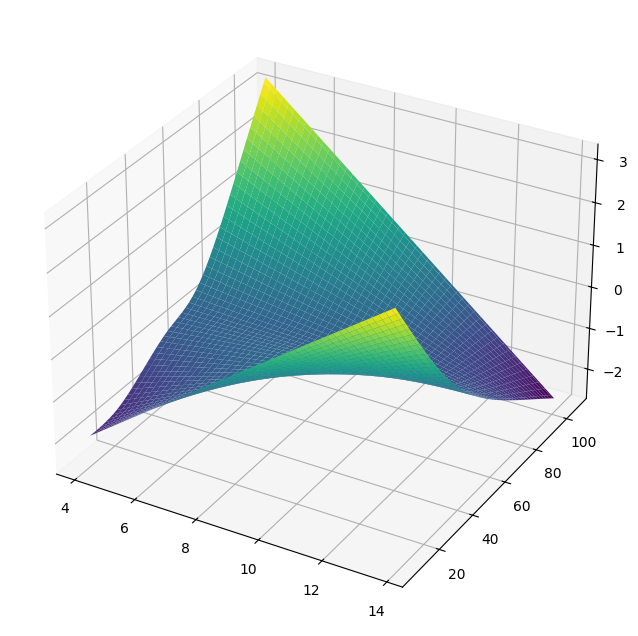

In [162]:
from mpl_toolkits import mplot3d

plt.ion()
plt.rcParams["figure.figsize"] = (12, 8)
XX = gam_with_interaction.generate_X_grid(term=10, meshgrid=True)
Z = gam_with_interaction.partial_dependence(term=10, X=XX, meshgrid=True)
ax = plt.axes(projection="3d")
ax.plot_surface(XX[0], XX[1], Z, cmap="viridis")

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:

In [161]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ebm_global = ebm.explain_global()
    show(ebm_global)

    ebm_local = ebm.explain_local(X_train, y_train)
    show(ebm_local)

<!-- http://127.0.0.1:7001/7313524752/ -->

<!-- http://127.0.0.1:7001/7497422672/ -->